In [1]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from scipy.stats import norm
from splotch.utils import savagedickey

In [2]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata_betas = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_celltype_betas.h5ad'))

### Fig5: temporal variation in expression of cellular signals implicated in MCP analysis

In [3]:
# One row per gene, generate KDE plots showing the posterior Beta density for each gene in each colon region 
# (columns) across specified ages for given AARs + celltypes
def plot_temporal_expression_kde(genes, aar, celltype, t_ordered=['6m', '1yr', '2yr'], xlim=None, ylim=None):
    
    # Plot in successively darker shades of gray
    cmap = plt.cm.binary
    cnorm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    
    region_colors = {'Proximal':'blue', 'Middle':'orange', 'Distal':'green'}
    
    fig, ax = plt.subplots(len(genes), 3, figsize=(7, 1.5*len(genes)+1), constrained_layout=True)

    for i, g in enumerate(genes):            
        for j, reg in enumerate(['Proximal', 'Middle', 'Distal']):
            if len(genes) > 1:
                axij = ax[i,j]
            else:
                axij = ax[j]

            for k, age in enumerate(t_ordered):
                cond = '%s BL6WT.%s' % (age, reg)
                inds = np.logical_and(adata_betas.obs.condition==cond, 
                                      adata_betas.obs.annotation==aar)
                inds = np.logical_and(adata_betas.obs.celltype==celltype, inds)
                
                mu = adata_betas[inds, g].X.squeeze()
                sigma = adata_betas[inds, g].layers['X_stds'].squeeze()

                d = np.random.normal(loc=mu, scale=sigma, size=1000)
                sns.kdeplot(d, label=age, ax=axij, fill=False, color=cmap(cnorm(k+1)))

            axij.set_xlim(xlim)
            axij.set_ylim(ylim)
            axij.set_title('%s (%s)' % (g,reg[0]), color=region_colors[reg], fontsize=14)

            if j == 0:
                axij.set_ylabel(r'$p(\beta)$', fontsize=14)
            else:
                axij.set_ylabel('')

            if i == len(genes)-1:
                axij.set_xlabel(r'$\beta$', fontsize=14)
            elif xlim is not None:
                axij.set_xticks([])

            axij.tick_params(axis='both', which='major', labelsize=12)

    
        if len(genes) > 1:
            ax[i,-1].legend(bbox_to_anchor=(1,0), loc='lower left')
        else:
            ax[-1].legend(bbox_to_anchor=(1,0), loc='lower left')
    
    return fig, ax

In [15]:
t_mid = ['6w', '8w', '12w']
t_young = ['0d', '1w', '2w', '3w', '4w']

def mirror_axlim(ax1, ax2, xlim=None, ylim=None):
    for i in range(ax1.shape[0]):
        # 1d plot
        if len(ax1.shape) == 1:
            if xlim is None:
                ax2[i].set_xlim(ax1[i].get_xlim())
            if ylim is None:
                ax2[i].set_ylim(ax1[i].get_ylim())
        # 2d plot
        else:
            for j in range(ax1.shape[1]):
                if xlim is None:
                    ax2[i,j].set_xlim(ax1[i,j].get_xlim())
                if ylim is None:
                    ax2[i,j].set_ylim(ax1[i,j].get_ylim())

# KDE plots for the given genes in the given AAR+celltype, separately for each major age group.
def plot_temporal_expression_kde_agegroups(genes, aar, celltype, xlim=None, ylim=None):
    title = aar.capitalize()
    if aar.startswith('crypt'):
        title = aar.split(' ')[1].capitalize()
    title += ' - %s' % celltype
    
    fig1, ax1 = plot_temporal_expression_kde(genes, aar, celltype, xlim=xlim, ylim=ylim)
    plt.suptitle(title, fontsize=14)
    
    fig2, ax2 = plot_temporal_expression_kde(genes, aar, celltype, t_ordered=t_mid, xlim=xlim, ylim=ylim)
    mirror_axlim(ax1, ax2, xlim, ylim)
    plt.suptitle(title, fontsize=14)
    
    fig1, ax3 = plot_temporal_expression_kde(genes, aar, celltype, t_ordered=t_young, xlim=xlim, ylim=ylim)
    mirror_axlim(ax1, ax3, xlim, ylim)
    plt.suptitle(title, fontsize=14)
    
    return ax1, ax2, ax3

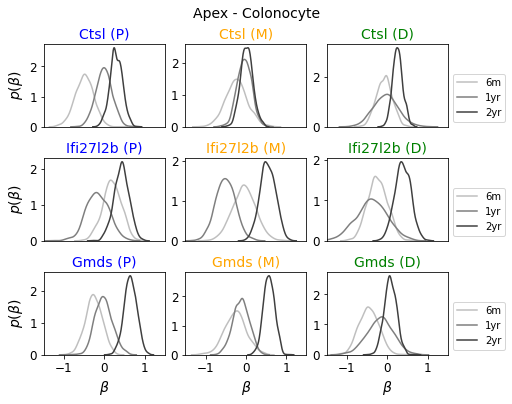

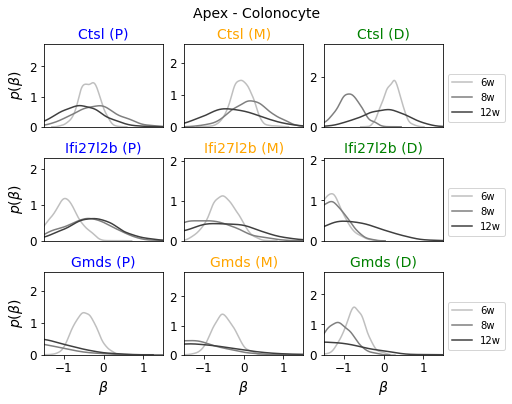

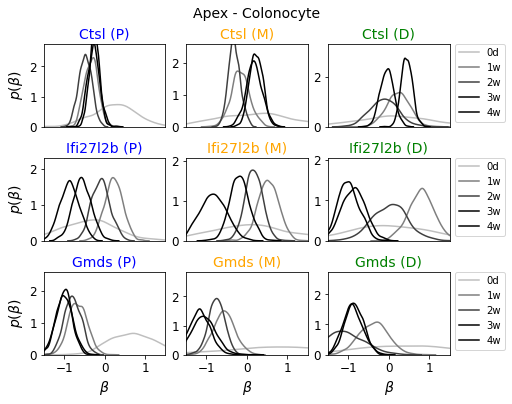

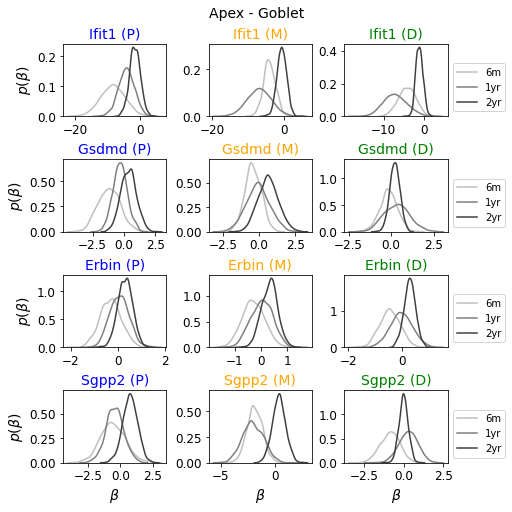

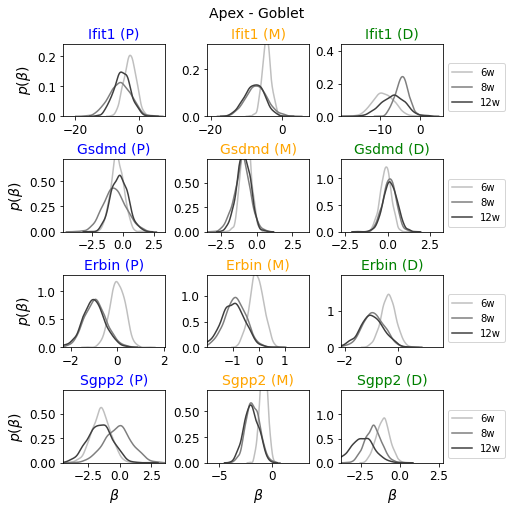

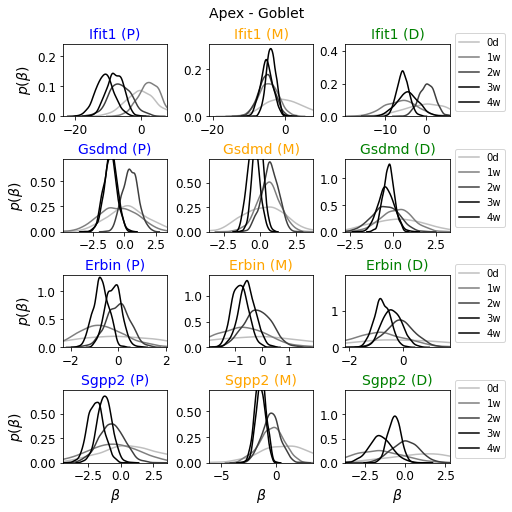

In [7]:
# Crypt base MCP2 down (up with aging)
genes_cc = ['Ctsl', 'Ifi27l2b', 'Gmds']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_cc, 'crypt apex', 'Colonocyte', xlim=(-1.5, 1.5))

genes_gob = ['Ifit1', 'Gsdmd', 'Erbin', 'Sgpp2']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_gob, 'crypt apex', 'Goblet')

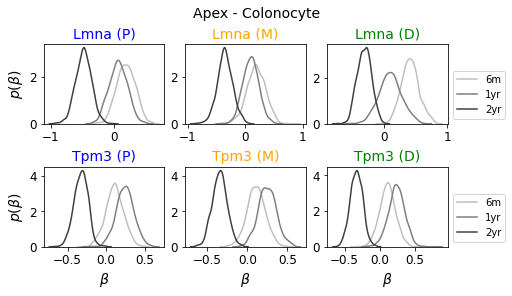

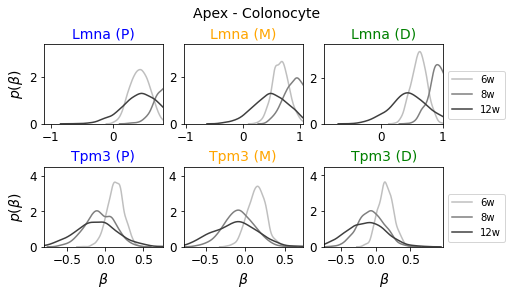

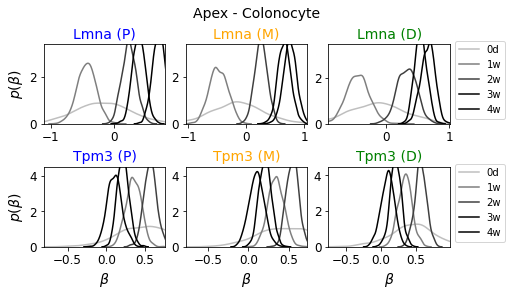

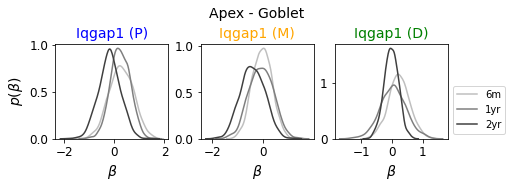

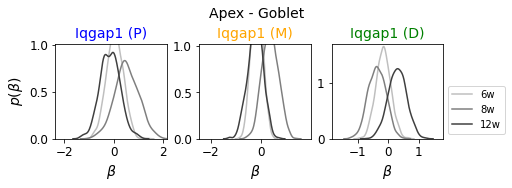

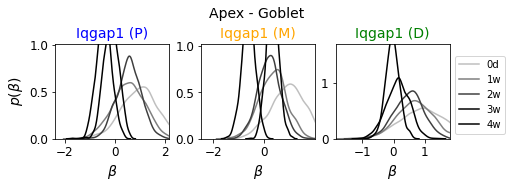

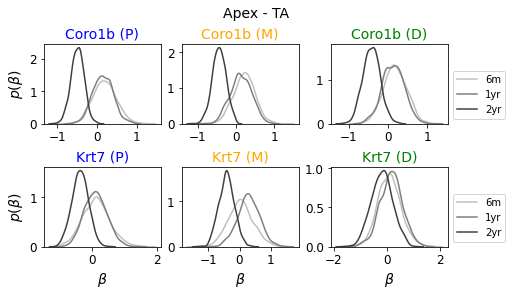

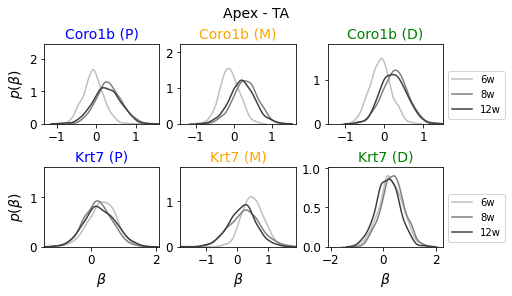

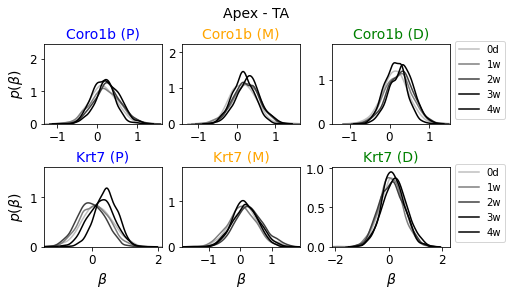

In [8]:
# Crypt apex MCP2 up (down with aging)
genes_cc = ['Lmna', 'Tpm3']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_cc, 'crypt apex', 'Colonocyte')

genes_gob = ['Iqgap1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_gob, 'crypt apex', 'Goblet')

genes_ta = ['Coro1b', 'Krt7']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'crypt apex', 'TA')

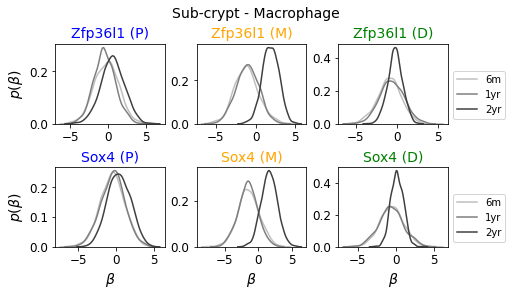

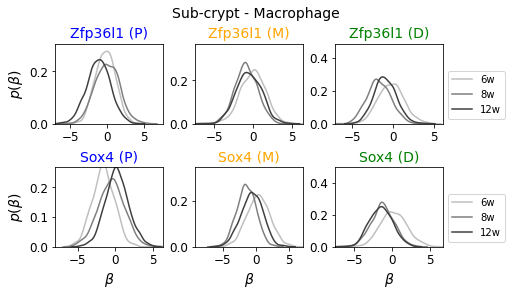

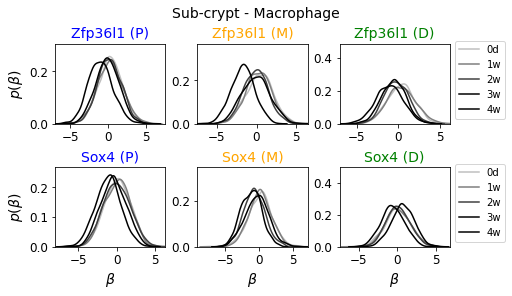

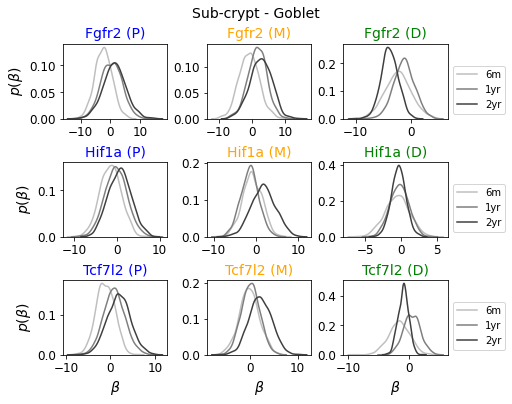

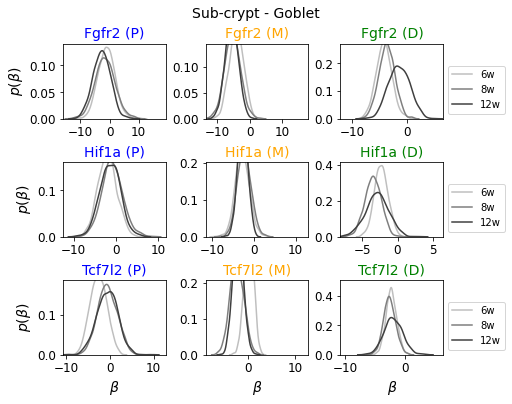

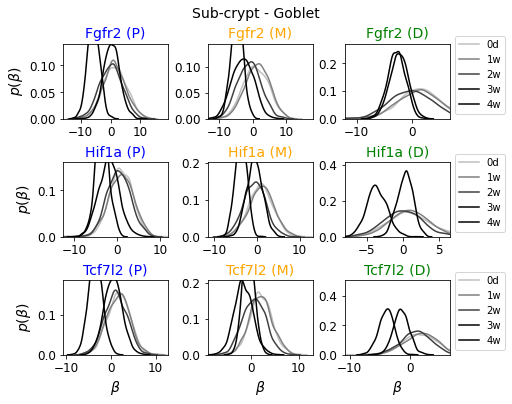

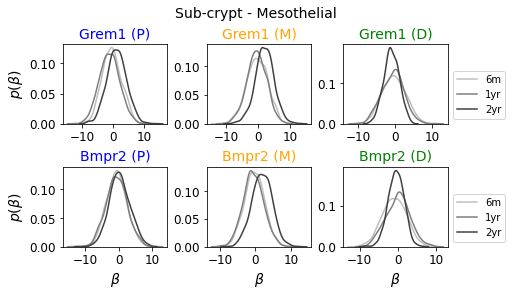

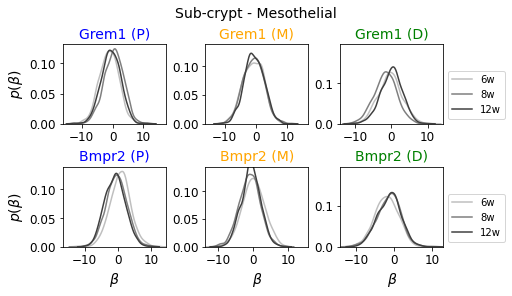

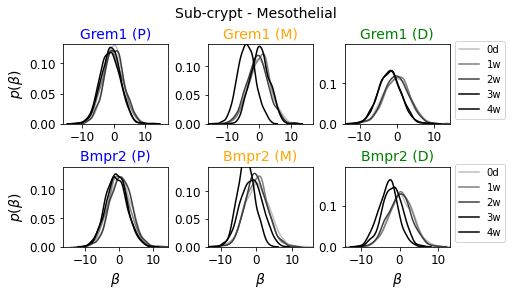

In [16]:
# Sub-crypt MCP2 down (up with age)
genes_macro = ['Zfp36l1', 'Sox4']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_macro, 'sub-crypt', 'Macrophage')

genes_gob = ['Fgfr2', 'Hif1a', 'Tcf7l2']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_gob, 'sub-crypt', 'Goblet')

genes_meso = ['Grem1', 'Bmpr2']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_meso, 'sub-crypt', 'Mesothelial')

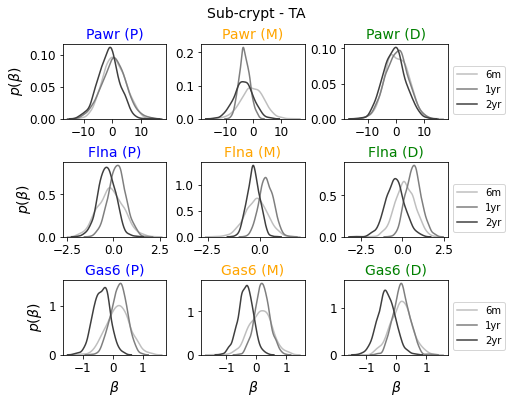

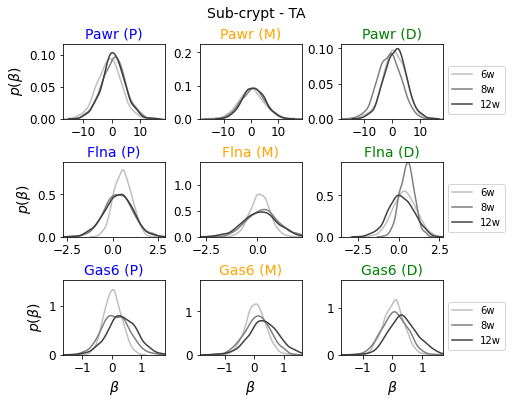

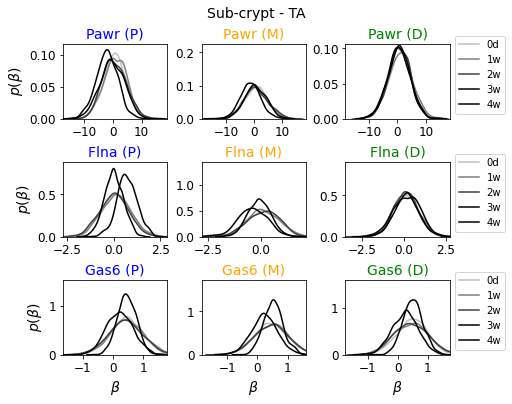

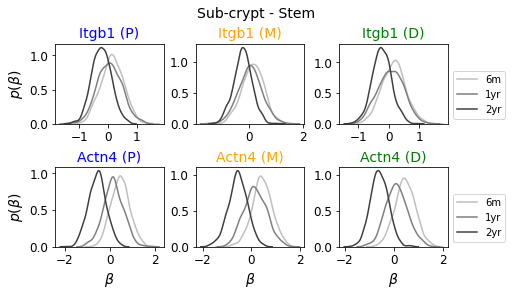

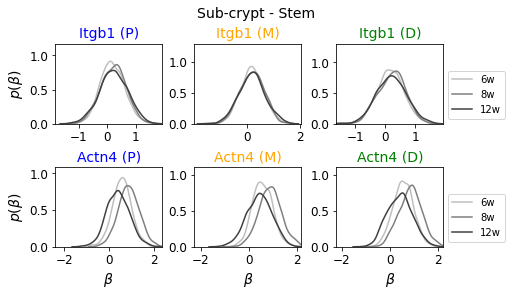

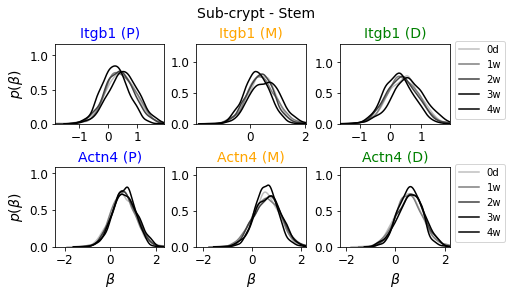

In [17]:
# Sub-crypt MCP2 up (down with age)
genes_ta = ['Pawr', 'Flna', 'Gas6']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'sub-crypt', 'TA')

genes_stem = ['Itgb1', 'Actn4']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_stem, 'sub-crypt', 'Stem')

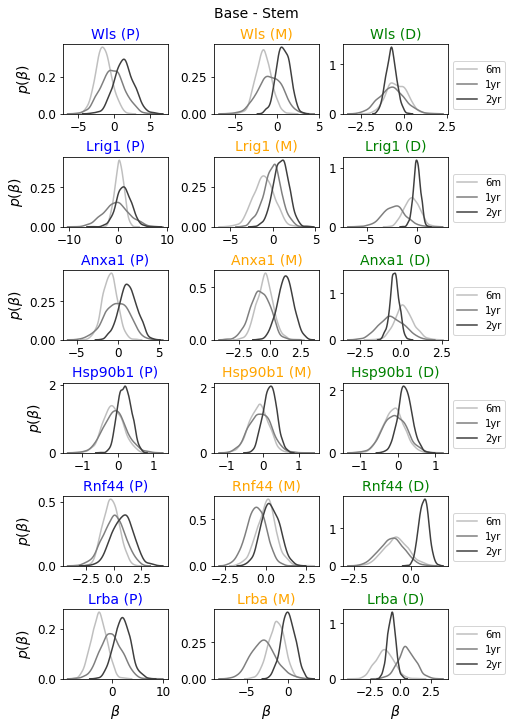

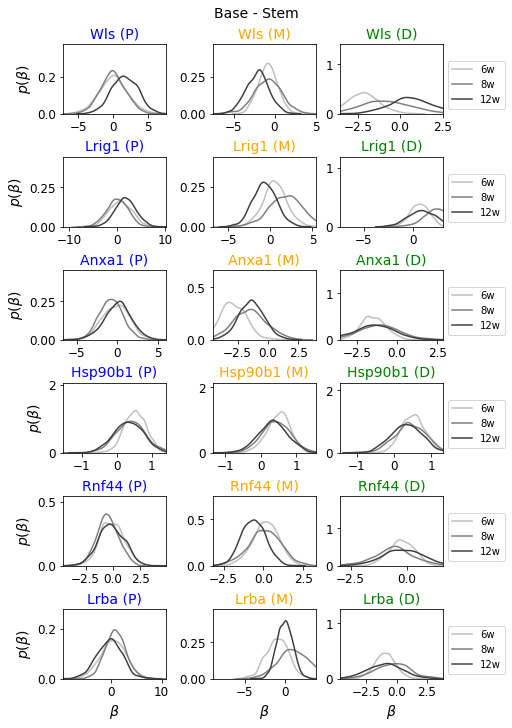

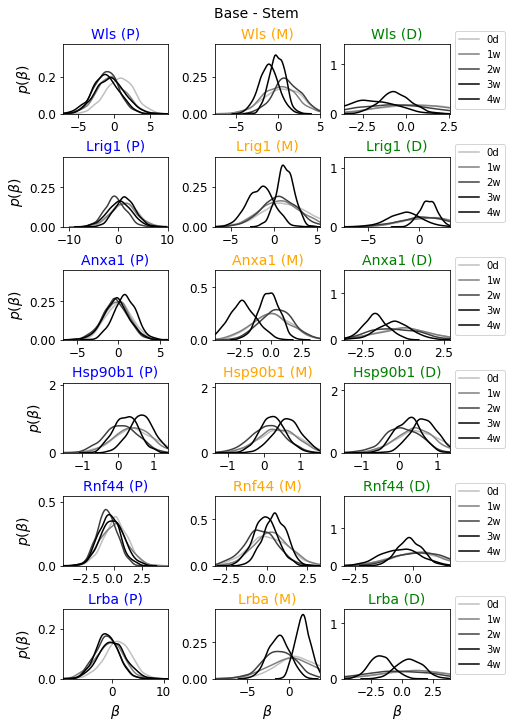

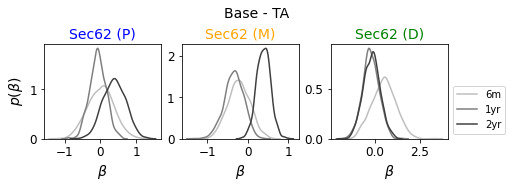

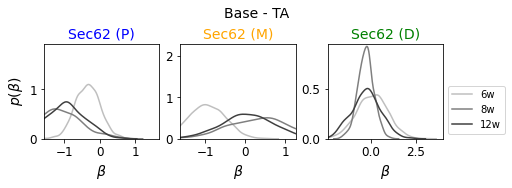

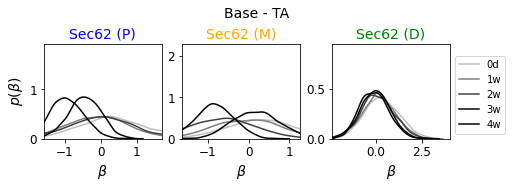

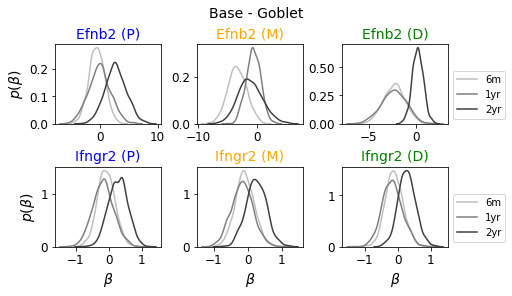

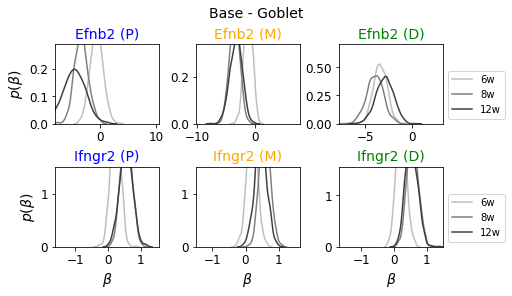

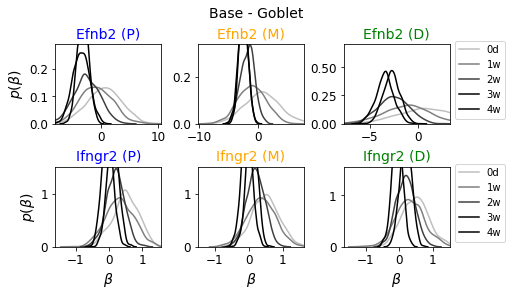

In [18]:
# Crypt base MCP1 up (up with age)
genes_stem = ['Wls', 'Lrig1', 'Anxa1', 'Hsp90b1', 'Rnf44', 'Lrba']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_stem, 'crypt base', 'Stem')

genes_ta = ['Sec62']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'crypt base', 'TA')

genes_gob = ['Efnb2', 'Ifngr2']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_gob, 'crypt base', 'Goblet')

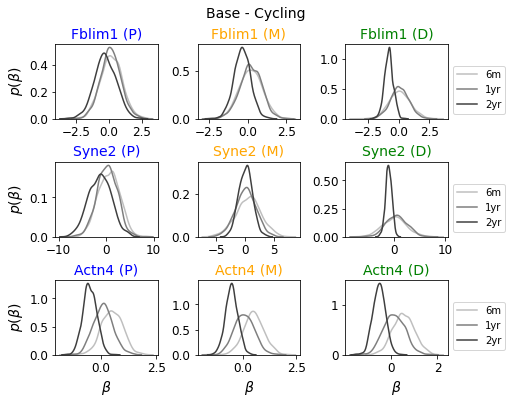

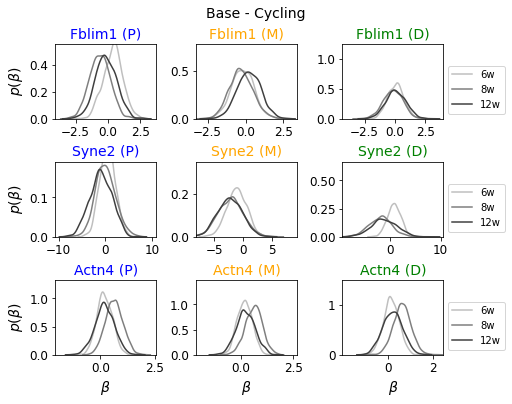

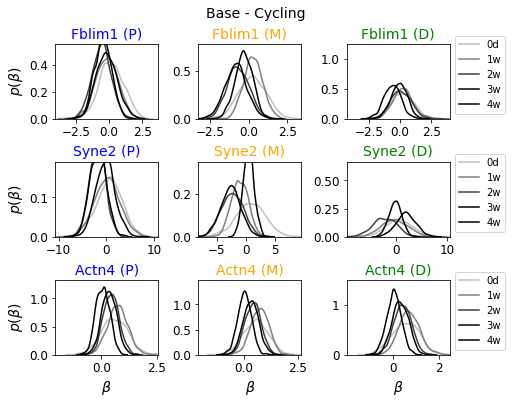

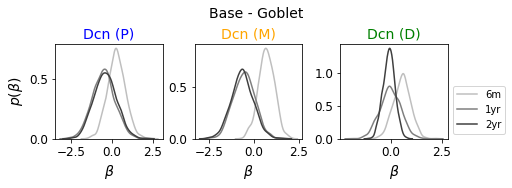

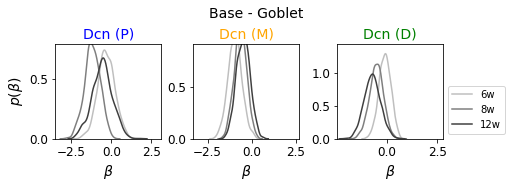

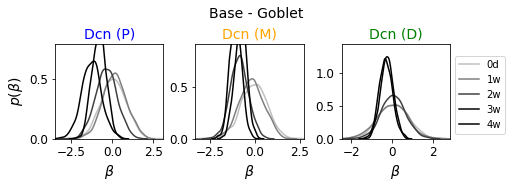

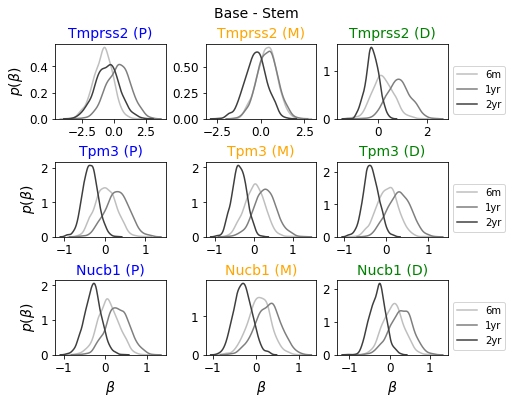

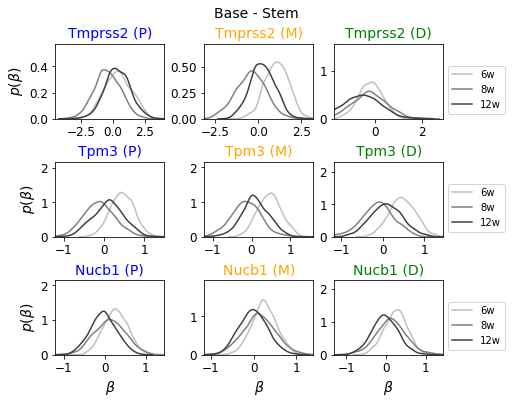

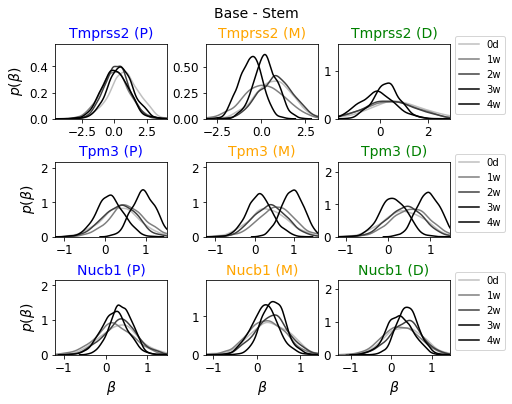

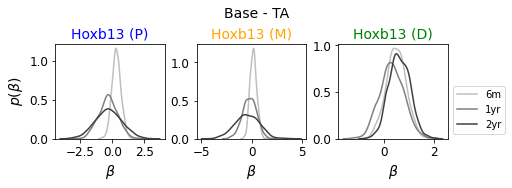

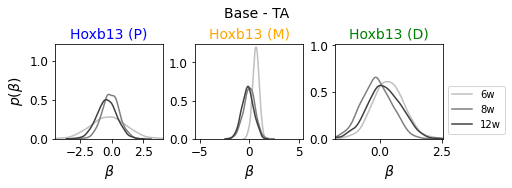

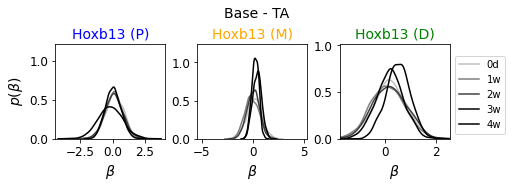

In [20]:
# Crypt base MCP1 down (down with age)
genes_cyc = ['Fblim1', 'Syne2', 'Actn4']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_cyc, 'crypt base', 'Cycling')

genes_gob = ['Dcn']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_gob, 'crypt base', 'Goblet')

genes_stem = ['Tmprss2', 'Tpm3', 'Nucb1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_stem, 'crypt base', 'Stem')

genes_ta = ['Hoxb13']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'crypt base', 'TA')

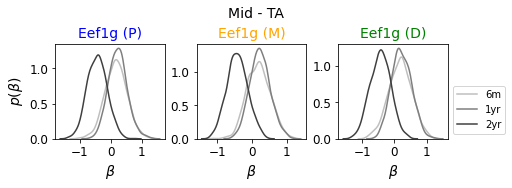

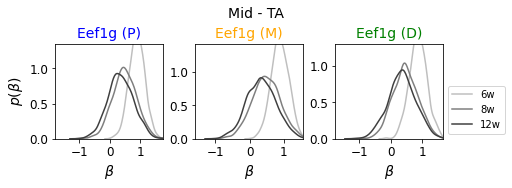

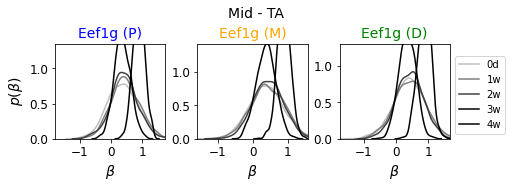

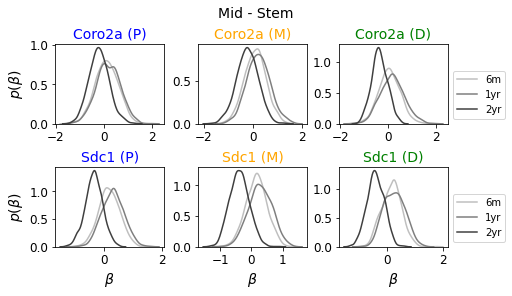

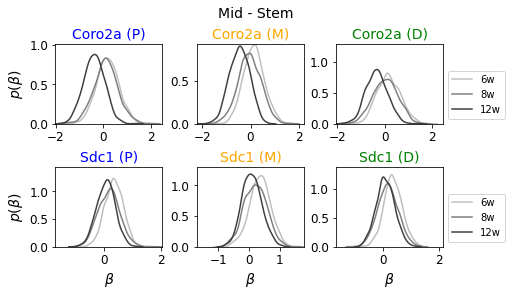

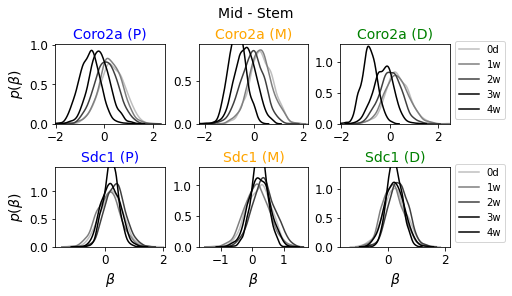

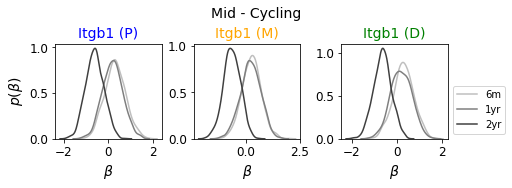

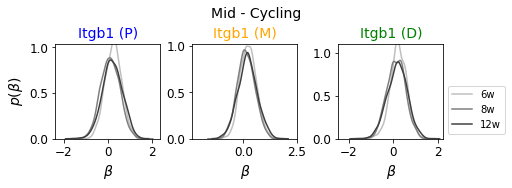

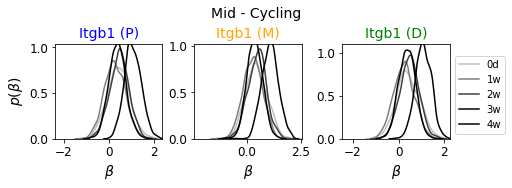

In [21]:
# Crypt mid MCP5 up (down with age)
genes_ta = ['Eef1g']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'crypt mid', 'TA')

genes_stem = ['Coro2a', 'Sdc1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_stem, 'crypt mid', 'Stem')

genes_cyc = ['Itgb1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_cyc, 'crypt mid', 'Cycling')

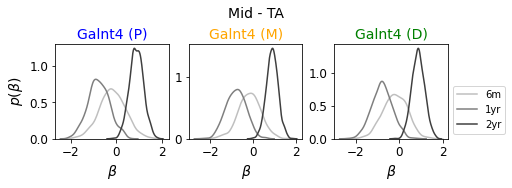

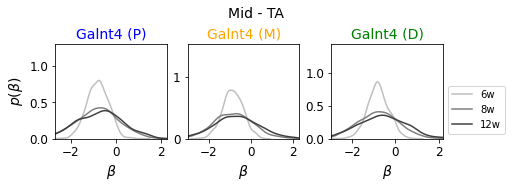

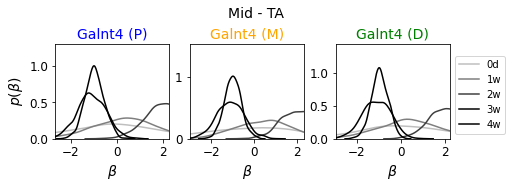

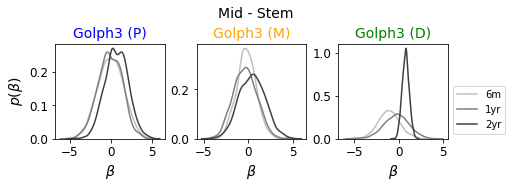

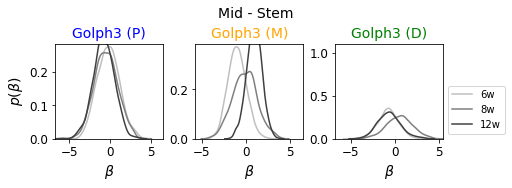

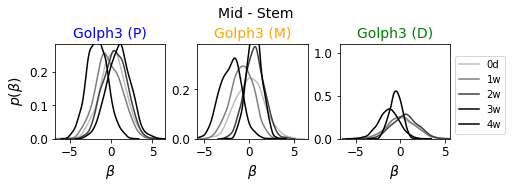

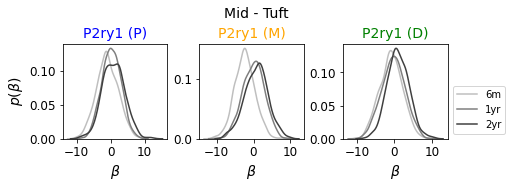

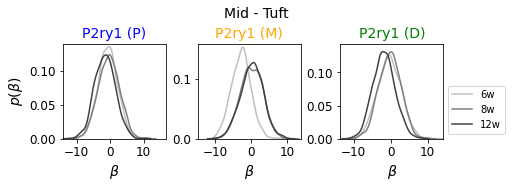

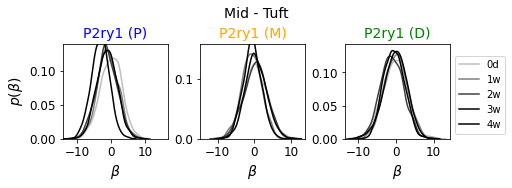

In [22]:
# Crypt mid MCP5 down (up with age)
genes_ta = ['Galnt4']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_ta, 'crypt mid', 'TA')

genes_stem = ['Golph3']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_stem, 'crypt mid', 'Stem')

genes_tuft = ['P2ry1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_tuft, 'crypt mid', 'Tuft')

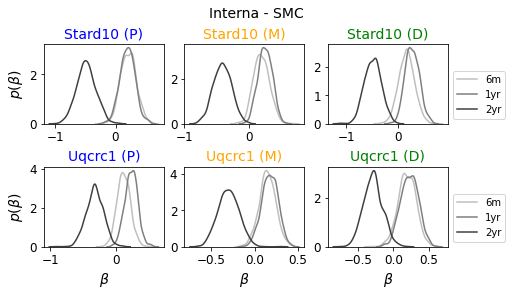

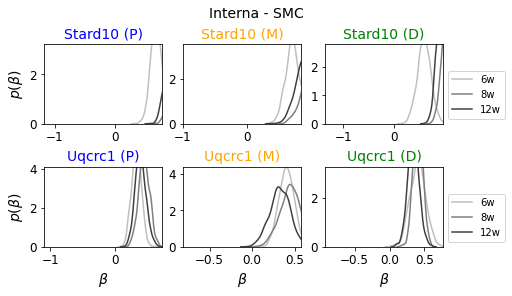

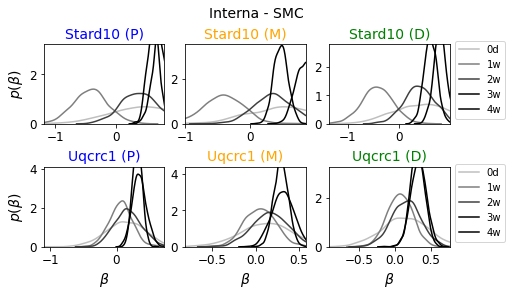

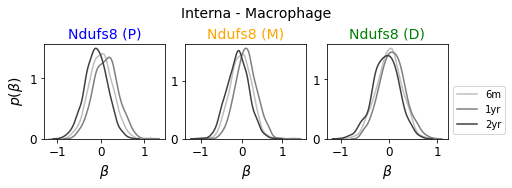

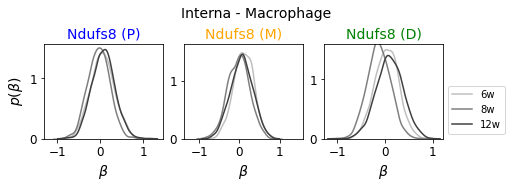

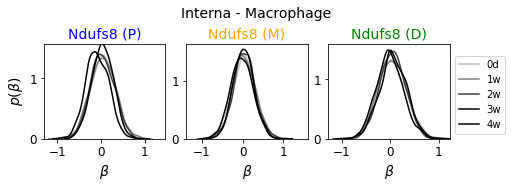

In [25]:
# Interna MCP1 down (down with age)
genes_smc = ['Stard10', 'Uqcrc1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_smc, 'interna', 'SMC')

genes_macro = ['Ndufs8']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_macro, 'interna', 'Macrophage')

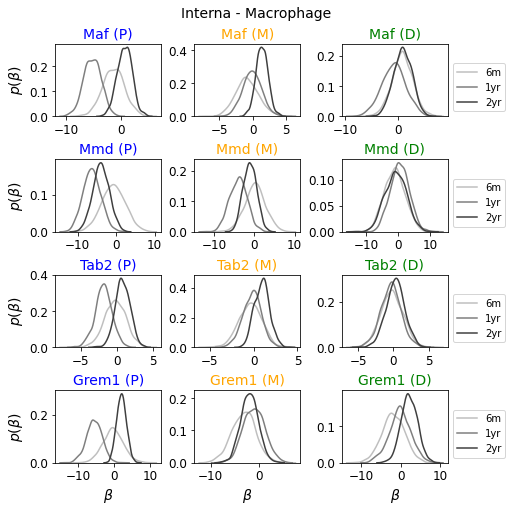

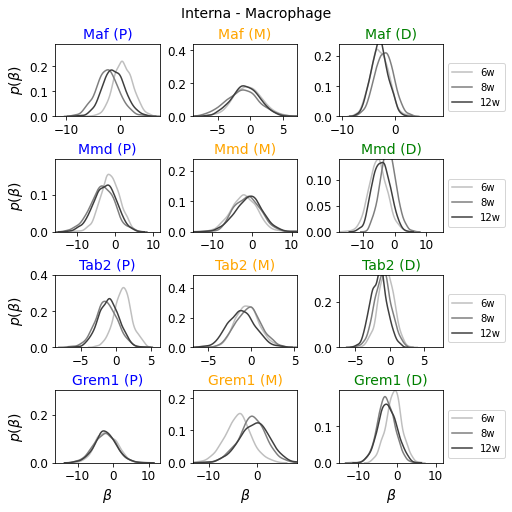

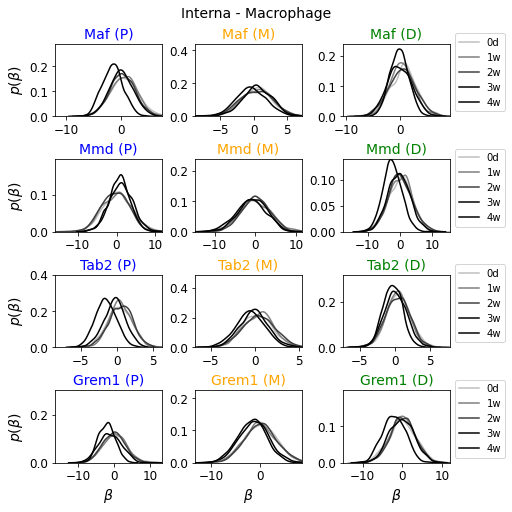

In [24]:
# Interna MCP1 up (up with age)
genes_macro = ['Maf', 'Mmd', 'Tab2', 'Grem1']
ax1, ax2, ax3 = plot_temporal_expression_kde_agegroups(genes_macro, 'interna', 'Macrophage')